Best solution:
   Location: (np.float64(2.9917596262269113), np.float64(-4.9183236839875235))
   f = 3.6559842632628405


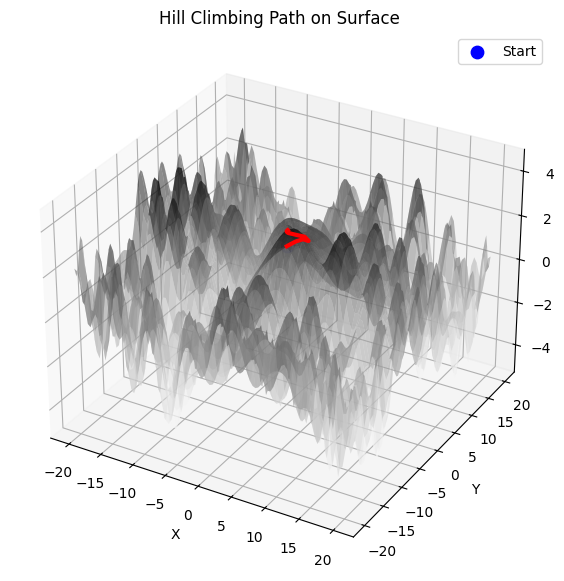

In [35]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numba import njit  # for optional speedup

# ProblemState
@dataclass(frozen=True)
class ProblemState:
    x: float
    y: float
    value: float
    gradient: np.ndarray

# Hill Climbing Algorithm with improvements
class HillClimber:
    def __init__(self, f_num, grad_num,
                 step=0.5, noise=0.05, max_iter=500, momentum=0.8):
        self.f_num = f_num
        self.grad_num = grad_num
        self.initial_step = step
        self.noise = noise
        self.max_iter = max_iter
        self.momentum = momentum

    def climb(self):
        step = self.initial_step
        val = self.f_num(0, 0)
        grad = np.array(self.grad_num(0, 0))
        state = ProblemState(0, 0, val, grad)
        path = [state]

        velocity = np.zeros(2)

        for _ in range(self.max_iter):
            grad = state.gradient
            norm = np.linalg.norm(grad)
            if norm < 1e-4:  # stop if gradient is very small
                break

            direction = grad / (norm + 1e-10)
            velocity = self.momentum * velocity + step * direction

            # Move and add Gaussian noise
            new_x = state.x + velocity[0] + np.random.normal(0, self.noise)
            new_y = state.y + velocity[1] + np.random.normal(0, self.noise)

            val = self.f_num(new_x, new_y)
            grad = np.array(self.grad_num(new_x, new_y))
            new_state = ProblemState(new_x, new_y, val, grad)

            if new_state.value > state.value:
                state = new_state
                path.append(state)
                step = min(step * 1.05, 1.0)  # adaptive step with upper limit
            else:
                step *= 0.5
                if step < 1e-4:
                    break

        return state, path

# Symbolic Function
x, y = sp.symbols('x y')
f = (sp.sin(x/4) + sp.cos(y/4) - sp.sin((x*y)/16)
     + sp.cos(x**2/16) + sp.sin(y**2/16))

grad_f = [sp.diff(f, v) for v in (x, y)]
f_num = sp.lambdify((x, y), f, 'numpy')
grad_num = sp.lambdify((x, y), grad_f, 'numpy')

f_num = njit(f_num)
grad_num = njit(grad_num)

# Run the Algorithm
hill = HillClimber(f_num, grad_num, step=0.5, noise=0.05, momentum=0.8)
best, path = hill.climb()

print("Best solution:")
print("   Location:", (best.x, best.y))
print("   f =", best.value)

# Plotting
X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(X, Y)
Z = f_num(X, Y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='Greys', alpha=0.5)

px = np.array([p.x for p in path])
py = np.array([p.y for p in path])
pz = np.array([p.value for p in path])

ax.plot(px, py, pz, color='red', linewidth=3, zorder=10)

ax.scatter(px, py, pz, color='red', s=40, edgecolor='black', zorder=15)

ax.scatter(0, 0, f_num(0, 0), color='blue', s=80, marker='o', label='Start', zorder=20)

ax.set_title('Hill Climbing Path on Surface')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x,y)')
ax.legend()

plt.show()